### DELETEME


In [1]:
import polars as pl
import sqlite3

DB_PATH = "/tgen_labs/altin/alphafold3/IEDB/2025-04-06/iedb_sqlite.db"

DB_SCHEMA_OVERRIDES = {
    "chain1_cur_v_gene": pl.String,
    "chain1_cur_j_gene": pl.String,
    "chain1_cur_v_dom_seq": pl.String,
    "chain1_cur_cdr3_seq": pl.String,
    "chain1_calc_v_gene": pl.String,
    "chain1_calc_j_gene": pl.String,
    "chain1_calc_v_dom_seq": pl.String,
    "chain1_calc_cdr3_seq": pl.String,
    "chain1_pro_seq": pl.String,
    "chain1_species": pl.Int32,
    "chain2_cur_v_gene": pl.String,
    "chain2_cur_j_gene": pl.String,
    "chain2_cur_v_dom_seq": pl.String,
    "chain2_cur_cdr3_seq": pl.String,
    "chain2_calc_v_gene": pl.String,
    "chain2_calc_j_gene": pl.String,
    "chain2_calc_v_dom_seq": pl.String,
    "chain2_calc_cdr3_seq": pl.String,
    "chain2_pro_seq": pl.String,
    "chain2_species": pl.Int32,
    "peptide": pl.String,
    "pdb_id": pl.String,
}

TRIAD_QUERY_STR = """
SELECT complex.pdb_id,
    curated_receptor.distinct_receptor_id
FROM complex
    JOIN tcell on complex.complex_id = tcell.complex_id
    JOIN tcell_receptor on tcell.tcell_id = tcell_receptor.tcell_id
    JOIN curated_receptor on tcell_receptor.curated_receptor_id = curated_receptor.distinct_receptor_id;"""

conn = sqlite3.connect(DB_PATH)
iedb_pdb_triads = pl.read_database(
    connection=conn,
    query=TRIAD_QUERY_STR,
    schema_overrides=DB_SCHEMA_OVERRIDES,
)

In [12]:
TRIAD_QUERY_STR = """
SELECT mhc_allele_restriction.*
FROM mhc_allele_restriction;"""

conn = sqlite3.connect(DB_PATH)
iedb_pdb_complex = pl.read_database(
    connection=conn,
    query=TRIAD_QUERY_STR,
    schema_overrides=DB_SCHEMA_OVERRIDES,
    infer_schema_length=100000,
)

## 1. Create blast+ blastp input fastas


In [5]:
import polars as pl

iedb_human_I = pl.read_csv("iedb/human_I/iedb_human_I.csv")
iedb_human_II = pl.read_csv("iedb/human_II/iedb_human_II.csv")
iedb_mouse_I = pl.read_csv("iedb/mouse_I/iedb_mouse_I.csv")
iedb_mouse_II = pl.read_csv("iedb/mouse_II/iedb_mouse_II.csv")

vdjdb_human_I = pl.read_csv("vdjdb/human_I/vdjdb_human_I.csv")
vdjdb_human_II = pl.read_csv("vdjdb/human_II/vdjdb_human_II.csv")
vdjdb_mouse_I = pl.read_csv("vdjdb/mouse_I/vdjdb_mouse_I.csv")
vdjdb_mouse_II = pl.read_csv("vdjdb/mouse_II/vdjdb_mouse_II.csv")

In [5]:
def generate_fastas(df, fname):
    with open(fname, "w") as f:
        for col in [
            "peptide",
            "mhc_1_seq",
            "mhc_2_seq",
            "tcr_1_seq",
            "tcr_2_seq",
        ]:
            unique_entries = df.select(col).unique()
            for row in unique_entries.iter_rows(named=True):
                seq = row[col]
                f.write(f">{seq}\n{seq}\n")

In [26]:
from tcr_format_parsers.common.TriadUtils import FORMAT_COLS

all_triads = pl.concat(
    [
        iedb_human_I.select(FORMAT_COLS),
        iedb_human_II.select(FORMAT_COLS),
        iedb_mouse_I.select(FORMAT_COLS),
        iedb_mouse_II.select(FORMAT_COLS),
        vdjdb_human_I,
        vdjdb_human_II,
        vdjdb_mouse_I,
        vdjdb_mouse_II,
    ]
)

generate_fastas(all_triads, "fasta_queries/all_triads.fasta")

## 2. Find pMHCs, TCRs, and full triads present in PDB


In [7]:
import polars as pl

# https://rnnh.github.io/bioinfo-notebook/docs/blast.html outfmt 10
schema = {
    "query_id": pl.String,
    "subject_id": pl.String,
    "per_identity": pl.Float64,
    "aln_length": pl.Int32,
    "mismatches": pl.Int32,
    "gap_opens": pl.Int32,
    "q_start": pl.Int32,
    "q_end": pl.Int32,
    "s_start": pl.Int32,
    "s_end": pl.Int32,
    "e_value": pl.Float64,
    "bit_score": pl.Float64,
}

blast_results = (
    pl.read_csv("pdb_blast_results/blast_result.csv", schema=schema)
    .with_columns(
        pl.col("subject_id").str.split("_").list.get(0).alias("pdb"),
        pl.col("subject_id").str.split("_").list.get(1).alias("segid"),
    )
    .drop("subject_id")
)

In [43]:
def find_matching(row, blast_result, thresh=90):
    pep_match = (
        blast_result.filter(
            pl.col("query_id") == row["peptide"],
            pl.col("per_identity") >= thresh,
        )
        .select("pdb")
        .unique()
    )
    mhc_1_match = (
        blast_result.filter(
            pl.col("query_id") == row["mhc_1_seq"],
            pl.col("per_identity") >= thresh,
        )
        .select("pdb")
        .unique()
    )
    mhc_2_match = (
        blast_result.filter(
            pl.col("query_id") == row["mhc_2_seq"],
            pl.col("per_identity") >= thresh,
        )
        .select("pdb")
        .unique()
    )
    tcr_1_match = (
        blast_result.filter(
            pl.col("query_id") == row["tcr_1_seq"],
            pl.col("per_identity") >= thresh,
        )
        .select("pdb")
        .unique()
    )
    tcr_2_match = (
        blast_result.filter(
            pl.col("query_id") == row["tcr_2_seq"],
            pl.col("per_identity") >= thresh,
        )
        .select("pdb")
        .unique()
    )

    pmhc_match_id = pep_match.join(mhc_1_match, on="pdb").join(
        mhc_2_match, on="pdb"
    )
    pmhc_match = pmhc_match_id.height > 0
    tcr_match_id = tcr_1_match.join(tcr_2_match, on="pdb")
    tcr_match = tcr_match_id.height > 0

    triad_match_id = (
        pep_match.join(tcr_1_match, on="pdb")
        .join(tcr_2_match, on="pdb")
        .join(mhc_1_match, on="pdb")
        .join(mhc_2_match, on="pdb")
    )
    triad_match = triad_match_id.height > 0

    new_row = row.copy()

    new_row["pmhc_match"] = pmhc_match
    new_row["pmhc_match_id"] = (
        pmhc_match_id[0].select("pdb").item() if pmhc_match else None
    )
    new_row["tcr_match"] = tcr_match
    new_row["tcr_match_id"] = (
        tcr_match_id[0].select("pdb").item() if tcr_match else None
    )
    new_row["triad_match"] = triad_match
    new_row["triad_match_id"] = (
        triad_match_id[0].select("pdb").item() if triad_match else None
    )

    return pl.DataFrame(new_row)

In [37]:
from mdaf3.FeatureExtraction import serial_apply, split_apply_combine

result = serial_apply(iedb_mouse_II, find_matching, blast_results, thresh=90)

Processing rows: 100%|██████████| 268/268 [00:32<00:00,  8.22it/s]


SchemaError: type String is incompatible with expected type Null

In [ ]:
resuasdf.filter(pl.col("triad_match"))

job_name,cognate,peptide,mhc_class,mhc_1_chain,mhc_1_species,mhc_1_name,mhc_1_seq,mhc_2_chain,mhc_2_species,mhc_2_name,mhc_2_seq,tcr_1_chain,tcr_1_species,tcr_1_seq,tcr_2_chain,tcr_2_species,tcr_2_seq,pmhc_match,pmhc_match_id,tcr_match,tcr_match_id,triad_match,triad_match_id
str,bool,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,bool,str,bool,str
"""176aec5c779671222f393611797284…",true,"""FEAQKAKANKAVD""","""II""","""alpha""","""mouse""","""H2-IAb""","""EDDIEADHVGTYGISVYQSPGDIGQYTFEF…","""beta""","""mouse""","""H2-IAb""","""GNSERHFVVQFKGECYYTNGTQRIRLVTRY…","""alpha""","""mouse""","""KILTASFLLLGLHLSGVSGQQEKRDQQQVR…","""beta""","""mouse""","""EAAVTQSPRNKVAVTGGKVTLSCNQTNNHN…",true,"""1LNU""",true,"""4P23""",true,"""4P23"""
"""a88aa507699d2da84da1705aec6045…",true,"""FKAQKAKANKAVD""","""II""","""alpha""","""mouse""","""H2-IAb""","""EDDIEADHVGTYGISVYQSPGDIGQYTFEF…","""beta""","""mouse""","""H2-IAb""","""GNSERHFVVQFKGECYYTNGTQRIRLVTRY…","""alpha""","""mouse""","""KILTASFLLLGLHLSGVSGQQEKRDQQQVR…","""beta""","""mouse""","""EAAVTQSPRNKVAVTGGKVTLSCNQTNNHN…",true,"""1LNU""",true,"""4P23""",true,"""4P23"""
"""70b6492ffc04f2747187a039d7c86e…",false,"""FEAQKAKANAAVD""","""II""","""alpha""","""mouse""","""H2-IAb""","""EDDIEADHVGTYGISVYQSPGDIGQYTFEF…","""beta""","""mouse""","""H2-IAb""","""GNSERHFVVQFKGECYYTNGTQRIRLVTRY…","""alpha""","""mouse""","""KILTASFLLLGLHLSGVSGQQEKRDQQQVR…","""beta""","""mouse""","""EAAVTQSPRNKVAVTGGKVTLSCNQTNNHN…",true,"""4P23""",true,"""3RDT""",true,"""4P23"""


In [44]:
from mdaf3.FeatureExtraction import serial_apply, split_apply_combine

results = []

for i in range(90, 101, 1):
    result = serial_apply(
        iedb_mouse_II, find_matching, blast_results, thresh=i
    )
    results.append(result)

Processing rows:   0%|          | 0/268 [00:00<?, ?it/s]

Processing rows: 100%|██████████| 268/268 [00:31<00:00,  8.58it/s]


In [46]:
match_rate_pmhc = [
    r.filter(pl.col("pmhc_match")).height / r.height for r in results
]

match_rate_tcr = [
    r.filter(pl.col("tcr_match")).height / r.height for r in results
]

match_rate_triad = [
    r.filter(pl.col("triad_match")).height / r.height for r in results
]

thresh = list(range(90, 101, 1))

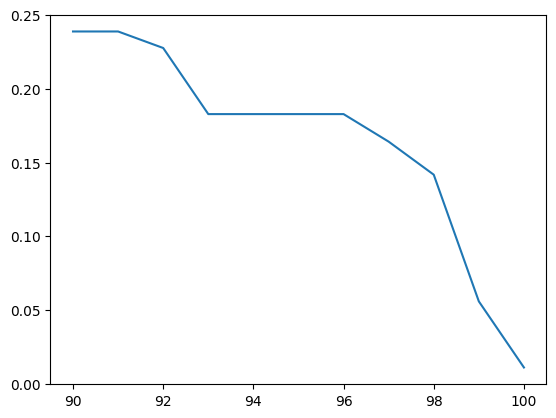

In [50]:
import matplotlib.pyplot as plt

plt.plot(thresh, match_rate_tcr, label="tcr")

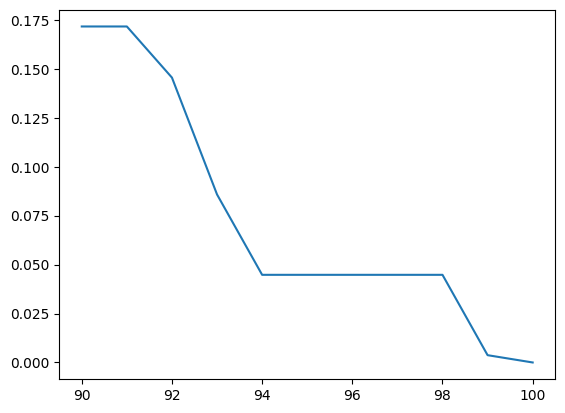

In [51]:
plt.plot(thresh, match_rate_pmhc, label="pmhc")

In [61]:
results[4].filter(pl.col("pmhc_match")).select("mhc_1_name").unique()

mhc_1_name
str
"""H2-IAg7"""
